In [2]:
import sys
!{sys.executable} -m pip install --user gplearn
!{sys.executable} -m pip install --user sympy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from gplearn.genetic import SymbolicRegressor
from sympy import *
from utils import *

import random
import warnings
warnings.filterwarnings('ignore')

# Lotka-Volterra prey-predator dynamics

This example is adapted from Martin et al. (2018) Reverse-engineering ecological theory from data. 
https://doi.org/10.1098/rspb.2018.0422

Prey-predator population dynamics are governed by Lotka-Volterra equations:

$\frac{dP}{dt} = \beta_1 P - \beta_2 PD$

$\frac{dD}{dt} = -\beta_3 D + \beta_4 PD$

Here, $P$ and $D$ are the prey and predator population sizes respectively, $t$ is time and $\frac{dP}{dt}$ and $\frac{dD}{dt}$ are instantaneous growth rates of the respective populations. The model parameters are:

$\beta_1$: growth rate of prey in the absence of predation;

$\beta_2$: death rate of prey with predation;

$\beta_3$: death rate of predators in the absence of prey;

$\beta_4$: growth rate of the predators in the presence of prey.

Simulation of prey-predator population dynamics with Lotka-Volterra equations:

In [4]:
def generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0, noise=True):
    """
    Generates a simulated dataset using simple Lotka-Volterra dynamics.
    
    Parameters
    ----------
    
    max_time : maximum time to simulate until
    dt : time step for the simulation
    b1 : beta_1
    b2 : beta_2
    b3 : beta_3
    b4 : beta_4
    t0 : start time
    p0 : initial prey population size
    p1 : initial predator population size
    noise : boolean indicating whether to add some noise to the data
    
    Returns
    -------
    
    t_h : time vector
    p_h : prey population sizes
    d_h : predator population sizes
    """
    
    # Initial values
    t = t0
    p = p0
    d = d0

    # Histories
    t_h = [t]
    p_h = [p]
    d_h = [d]

    while t < max_time:
        t = t + dt
        p = p + (b1*p - b2*p*d)*dt
        d = d + (-b3*d + b4*p*d)*dt

        t_h.append(t)
        p_h.append(p)
        d_h.append(d)
    
    t_h = np.array(t_h)
    p_h = np.array(p_h)
    d_h = np.array(d_h)
    if noise:
        p_h = p_h + np.random.normal(loc=0, scale=0.1, size=len(t_h))
        d_h = d_h + np.random.normal(loc=0, scale=0.1, size=len(t_h))
        
    p_h[p_h < 0] = 0
    d_h[d_h < 0] = 0

    return t_h, p_h, d_h


def derivative(p, d, b1, b2, b3, b4):
    """
    Returns the derivative of Lotka-Volterra equations. 
    """
    
    return np.array([p*(b1 - b2*d), d*(-b3 + b4*p)])

[0.000e+00 1.000e-01 2.000e-01 ... 9.990e+01 1.000e+02 1.001e+02]


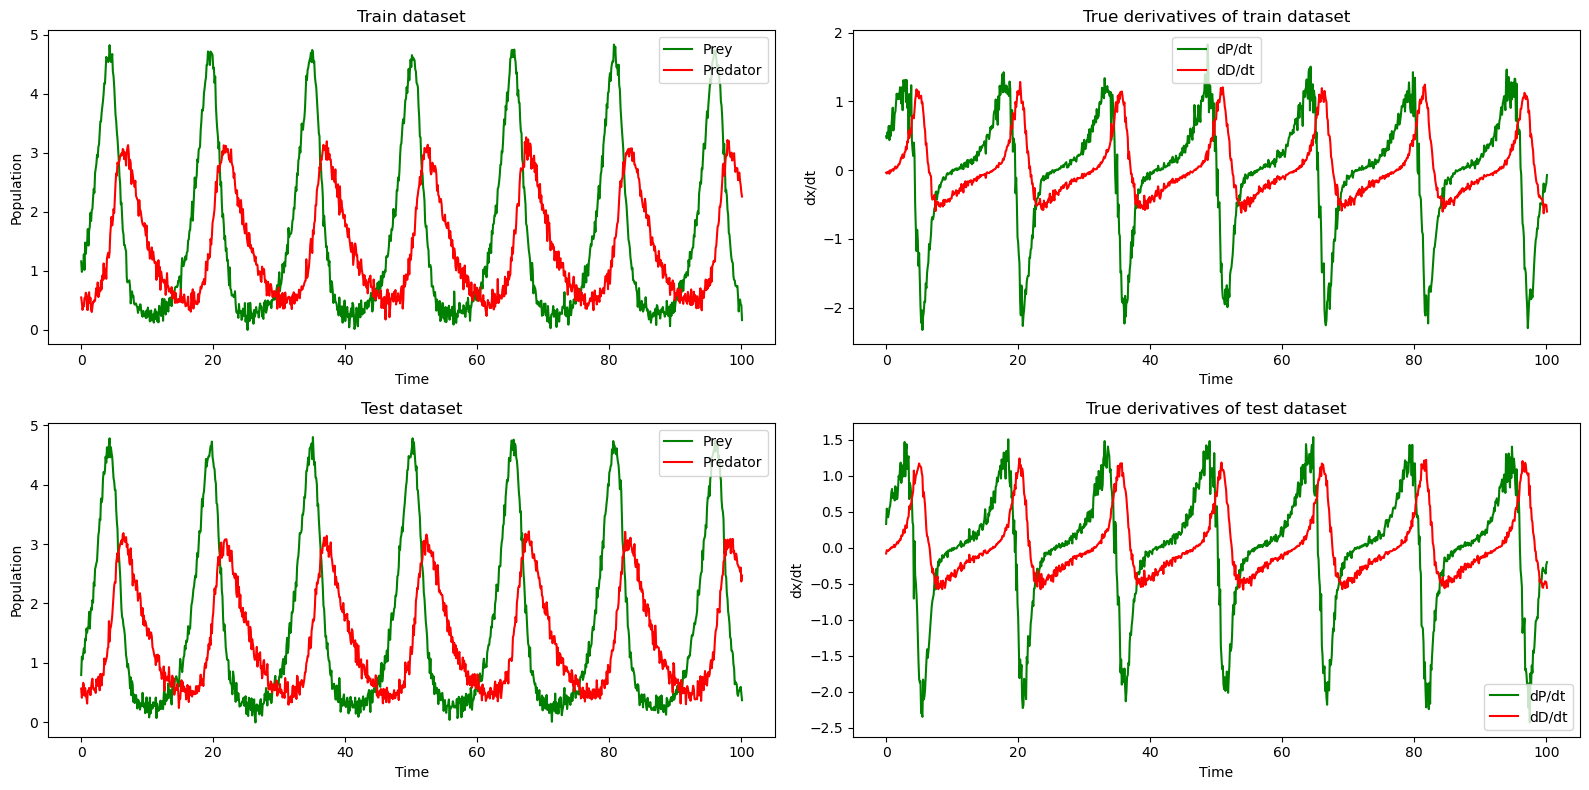

In [129]:
np.random.seed(1)
max_time = 100
dt = 0.1
b1 = 0.7
b2 = 0.5
b3 = 0.3
b4 = 0.2
t0 = 0
p0 = 1
d0 = 0.5

t_train, p_train, d_train = generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0)
t_test, p_test, d_test = generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0)

der_train = derivative(p_train, d_train, b1, b2, b3, b4)
der_test = derivative(p_test, d_test, b1, b2, b3, b4)

x_train = np.vstack([p_train, d_train]).T
x_test = np.vstack([p_test, d_test]).T

plt.subplots(2, 2, figsize=(16, 8))

plt.subplot(221)
plt.plot(t_train, p_train, 'green', label="Prey")
plt.plot(t_train, d_train, 'red', label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Train dataset")

plt.subplot(222)
plt.plot(t_train, der_train[0], 'green', label="dP/dt")
plt.plot(t_train, der_train[1], 'red', label="dD/dt")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.title("True derivatives of train dataset")

plt.subplot(223)
plt.plot(t_test, p_test, 'green', label="Prey")
plt.plot(t_test, d_test, 'red', label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Test dataset")

plt.subplot(224)
plt.plot(t_test, der_test[0], 'green', label="dP/dt")
plt.plot(t_test, der_test[1], 'red', label="dD/dt")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.title("True derivatives of test dataset")
plt.tight_layout()
plt.show()

### Problem 1: Discovering the mathematical relationships between variables and response in simulated data

First, let's assume we do not know the generative model. We generate the prey-predator data and use some method to infer derivatives, e.g., using cubic splines, using just the population data.

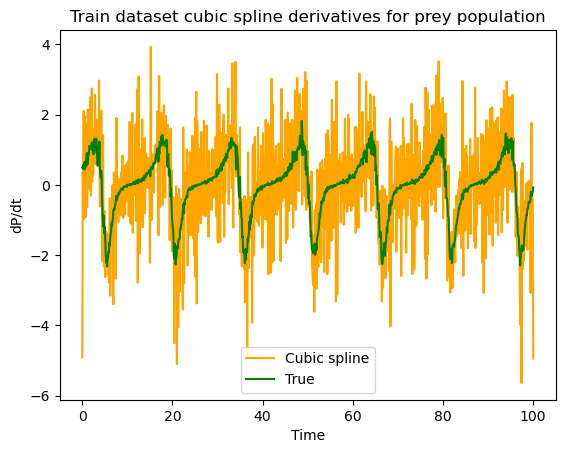

In [17]:
y_cs_p = CubicSpline(t_train, p_train)(t_train, 1)  # First order derivatives of the PREY population
plt.figure()
plt.plot(t_train, y_cs_p, "orange", label="Cubic spline")
plt.plot(t_train, der_train[0], "green", label="True")
plt.xlabel("Time")
plt.ylabel("dP/dt")
plt.title("Train dataset cubic spline derivatives for prey population")
plt.legend()
plt.show()

Calculation of derivative induces some noise -- let's see how SR fares.

Let's use **gplearn** implementation of symbolic regression for *Python*: https://gplearn.readthedocs.io/en/stable/

This implementation only allows one equation to be returned instead of a set (unlike most other SR packages), so let's train 10 models:

In [7]:
def SR(x_train, y_train, x_test, y_test, method, pc, n, rng, population_size=3000, generations=20):
    """
    A helper function to run n instances of the gplearn symbolic regressor.
    
    Parameters
    ----------
    
    x_train : train population sizes of both prey or predator (n_samples x 2 matrix)
    y_train : train response (the derivatives or population sizes) for either prey or predator (an array)
    x_test : test population sizes
    y_test : test responses
    method : initialization method (see gplearn documentation)
    pc : parsimony coefficient (see gplearn documentation)
    rng : random seed value
    population_size: the size of the symbolic representation population (see gplearn documentation)
    generations : number of iterations (see gplearn documentation)
    
    Returns
    -------
    
    pandas DataFrame with test scores, equation lengths and equations.
    """

    eqs = []
    test_scores = []
    lengths = []
    for i in range(n):                                                     
        est_gp = SymbolicRegressor(feature_names=["p", "d"],            # Variable symbols
                                   verbose=0,                           # Disable full output
                                   function_set=["add", "mul", "div"],  # The alphabet (or library) of mathematical expressions
                                   population_size=population_size,     # Population size for GP algorithm
                                   generations=generations,             # Number of generations
                                   parsimony_coefficient=pc,            # Penalty for long equations (prefer smaller models)
                                   init_method=method,                  # Method of tree initialization, varying results
                                   max_samples=0.9,                     # 10% of samples are for validation
                                   random_state=rng[i])

        est_gp.fit(x_train, y_train)                                   # We fit the data to the SR model
        eq = str(est_gp)                                   # We get the final equation
        test_score = np.round(est_gp.score(x_test, y_test), 2)  # Let's compare test dataset output to the true test derivatives
        length = est_gp.run_details_['best_length'][-1]    # Complexity of the best equation
        
        print("Model " + str(i+1) + ", R^2 score: " + str(test_score) + ", " + str(eq))
        eqs.append(eq)
        test_scores.append(test_score)
        lengths.append(length)
       
    return pd.DataFrame({"Test R^2": test_scores, "Length": lengths, "Equation": eqs})

In [252]:
eqs_p = SR(x_train, y_cs_p, x_test, der_test[0], n=10, rng=range(10), method="grow", pc=0.001)
eqs_p

Model 1, R^2 score: 0.97, add(mul(add(add(d, d), mul(d, d)), mul(mul(d, -0.025), mul(p, 0.831))), div(p, add(add(d, d), add(d, 0.967))))
Model 2, R^2 score: 0.99, mul(add(div(mul(-0.182, p), div(0.267, d)), p), add(-0.190, 0.923))
Model 3, R^2 score: 0.98, div(add(add(p, mul(mul(d, d), mul(p, -0.441))), -0.392), add(d, div(0.268, 0.242)))
Model 4, R^2 score: 0.97, mul(add(div(-0.271, -0.789), mul(p, div(d, d))), add(0.562, mul(-0.383, d)))
Model 5, R^2 score: 0.94, mul(add(0.816, mul(-0.613, d)), p)
Model 6, R^2 score: 0.99, mul(0.850, mul(0.850, mul(p, add(mul(-0.639, d), 0.850))))
Model 7, R^2 score: 0.97, add(p, mul(p, add(mul(-0.317, add(d, mul(mul(0.155, d), d))), -0.488)))
Model 8, R^2 score: 1.0, mul(p, add(0.720, mul(-0.509, d)))
Model 9, R^2 score: 0.98, mul(add(mul(-0.467, d), 0.599), p)
Model 10, R^2 score: 0.99, add(mul(mul(d, p), -0.345), div(p, add(0.982, d)))


,Test R^2,Length,Equation
0,0.97,25,"add(mul(add(add(d, d), mul(d, d)), mul(mul(d, ..."
1,0.99,13,"mul(add(div(mul(-0.182, p), div(0.267, d)), p)..."
2,0.98,17,"div(add(add(p, mul(mul(d, d), mul(p, -0.441)))..."
3,0.97,15,"mul(add(div(-0.271, -0.789), mul(p, div(d, d))..."
4,0.94,7,"mul(add(0.816, mul(-0.613, d)), p)"
5,0.99,11,"mul(0.850, mul(0.850, mul(p, add(mul(-0.639, d..."
6,0.97,15,"add(p, mul(p, add(mul(-0.317, add(d, mul(mul(0..."
7,1.00,7,"mul(p, add(0.720, mul(-0.509, d)))"
8,0.98,7,"mul(add(mul(-0.467, d), 0.599), p)"
9,0.99,11,"add(mul(mul(d, p), -0.345), div(p, add(0.982, ..."


We see that the equations are not easily readable, furthermore, they can be simplified. Let's use **SymPy** to simplify the expressions. Unfortunately, SymPy does not define division or subtraction the usual way (rather, they are represented through multiplication and addition, see https://docs.sympy.org/latest/tutorial/manipulation.html) so we need to convert the expression to accomodate for that (our provided custom functions will do that job, i.e., *convert_s* from utils).

In [9]:
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in eqs_p["Equation"]:
    print(simplify(convert_s(eq)))

p*(-0.020775*d**2*(d + 2)*(3*d + 0.967) + 1)/(3*d + 0.967)
p*(0.733 - 0.499647940074906*d)
(-0.441*d**2*p + p - 0.392)/(d + 1.10743801652893)
-(0.383*d - 0.562)*(p + 0.343472750316857)
p*(0.816 - 0.613*d)
p*(0.614125 - 0.4616775*d)
p*(-0.049135*d**2 - 0.317*d + 0.512)
p*(0.72 - 0.509*d)
p*(0.599 - 0.467*d)
p*(-0.345*d*(d + 0.982) + 1)/(d + 0.982)


Here we get a really nice and elegant output. It may be obvious already -- most of these are indeed one of the Lotka-Volterra equations in predator-prey population dynamics: 

$\frac{dP}{dt} = \beta_1 P - \beta_2 PD = P(\beta_1−\beta_2 D)$

To be exact, this equation represents prey population -- exactly as we had hoped to find. Not only we found the exact underlying mechanics of the prey population dynamics *de novo*, but at the same time we inferred its parameters as well: $\beta_1$ and $\beta_2$. They are quite close to the true parameter values as well (0.7 and 0.5)!

Let's display the 8-th equation in a pretty format, evaluate it and visualize the results:

In [92]:
eq = simplify(convert_s(eqs_p["Equation"][7]))
eq

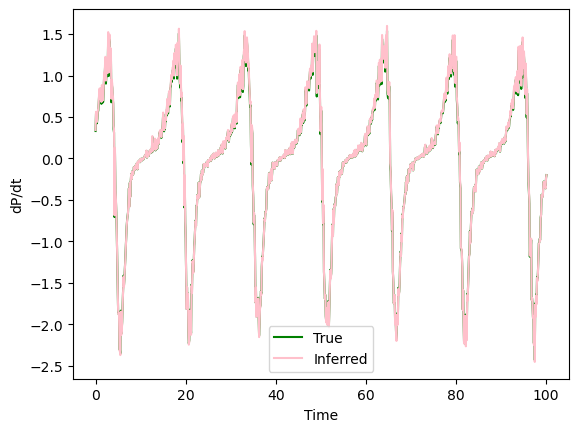

In [11]:
p = p_test
d = d_test
y_sol = eval(str(eq))

plt.figure()
plt.plot(t_test, der_test[0], "green", label="True")
plt.plot(t_test, y_sol, "pink", label="Inferred")
plt.xlabel("Time")
plt.ylabel("dP/dt")
plt.legend()
plt.show()

Beautiful results! Symbolic regression was not at all confused by the added noise from cubic spline derivative computation.

#### Problem 1a:

Run 10 instances of the symbolic regressor for the simulated PREDATOR population and check the resulting equations. Can you see good solutions? If so, pick out your favorite and report it, visualizing the inferred fit versus the true data.

Hint: remember to compute first order derivatives of the predator population.

#### Code and answers:

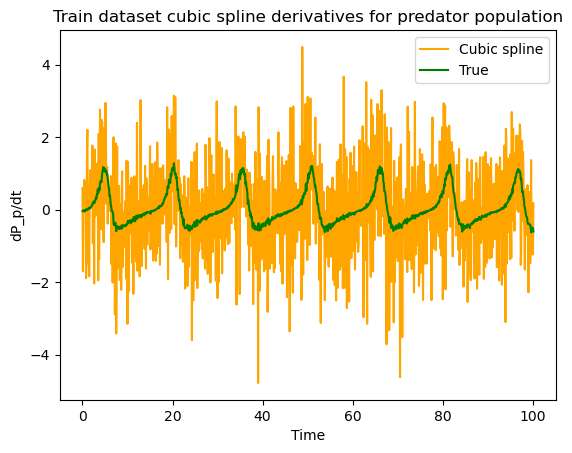

In [16]:
y_cs_d = CubicSpline(t_train, d_train)(t_train, 1)  # First order derivatives of the predator population
plt.figure()
plt.plot(t_train, y_cs_d, "orange", label="Cubic spline")
plt.plot(t_train, der_train[1], "green", label="True")
plt.xlabel("Time")
plt.ylabel("dP_p/dt")
plt.title("Train dataset cubic spline derivatives for predator population")
plt.legend()
plt.show()

In [18]:
eqs_d = SR(x_train, y_cs_d, x_test, der_test[1], n=10, rng=range(10), method="grow", pc=0.001)
eqs_d

Model 1, R^2 score: 0.99, mul(mul(0.182, d), add(add(-0.902, -0.544), p))
Model 2, R^2 score: 0.86, mul(d, mul(add(-0.943, p), 0.160))
Model 3, R^2 score: 0.8, add(mul(add(p, 0.661), 0.309), -0.606)
Model 4, R^2 score: 0.94, mul(d, add(-0.142, add(-0.142, mul(p, 0.226))))
Model 5, R^2 score: 0.78, add(mul(0.222, p), -0.291)
Model 6, R^2 score: 0.98, mul(add(-0.372, add(-0.928, p)), mul(d, 0.189))
Model 7, R^2 score: 0.81, add(-0.459, mul(0.270, p))
Model 8, R^2 score: 0.7, mul(0.214, add(-0.880, p))
Model 9, R^2 score: 0.93, mul(add(-0.620, add(p, -0.836)), mul(d, 0.148))
Model 10, R^2 score: 0.56, mul(p, mul(0.051, p))


,Test R^2,Length,Equation
0,0.99,9,"mul(mul(0.182, d), add(add(-0.902, -0.544), p))"
1,0.86,7,"mul(d, mul(add(-0.943, p), 0.160))"
2,0.80,7,"add(mul(add(p, 0.661), 0.309), -0.606)"
3,0.94,9,"mul(d, add(-0.142, add(-0.142, mul(p, 0.226))))"
4,0.78,5,"add(mul(0.222, p), -0.291)"
5,0.98,9,"mul(add(-0.372, add(-0.928, p)), mul(d, 0.189))"
6,0.81,5,"add(-0.459, mul(0.270, p))"
7,0.70,5,"mul(0.214, add(-0.880, p))"
8,0.93,9,"mul(add(-0.620, add(p, -0.836)), mul(d, 0.148))"
9,0.56,5,"mul(p, mul(0.051, p))"


In [19]:
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in eqs_d["Equation"]:
    print(simplify(convert_s(eq)))

0.182*d*(p - 1.446)
d*(0.16*p - 0.15088)
0.309*p - 0.401751
d*(0.226*p - 0.284)
0.222*p - 0.291
0.189*d*(p - 1.3)
0.27*p - 0.459
0.214*p - 0.18832
0.148*d*(p - 1.456)
0.051*p**2


In [105]:
eq_d = simplify(convert_s(eqs_d["Equation"][3]))
eq_d

The best results came with equation 0, 3 and 5. Below is the visualization of 3.

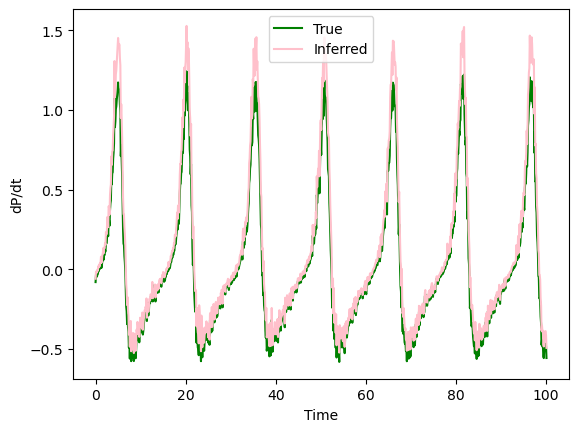

In [90]:
p = p_test
d = d_test
y_sol = eval(str(eq_d))

plt.figure()
plt.plot(t_test, der_test[1], "green", label="True")
plt.plot(t_test, y_sol, "pink", label="Inferred")
plt.xlabel("Time")
plt.ylabel("dP/dt")
plt.legend()
plt.show()

#### Problem 1b:

Take two best performing equations, one for prey (you can use the one given by us above) and one for predators (your result from problem 1a), and simulate a new dataset using the inferred model parameters from the two equations. Plot the results and compare them to the original simulated data in one plot.

Hint: use **generate_LV_samples** function without noise and parameterize it according to the results.

As a reference, Lotka-Volterra functional forms used here are as follows:

$\frac{dP}{dt} = \beta_1 P - \beta_2 PD$

$\frac{dD}{dt} = -\beta_3 D + \beta_4 PD$

#### Code and answers:

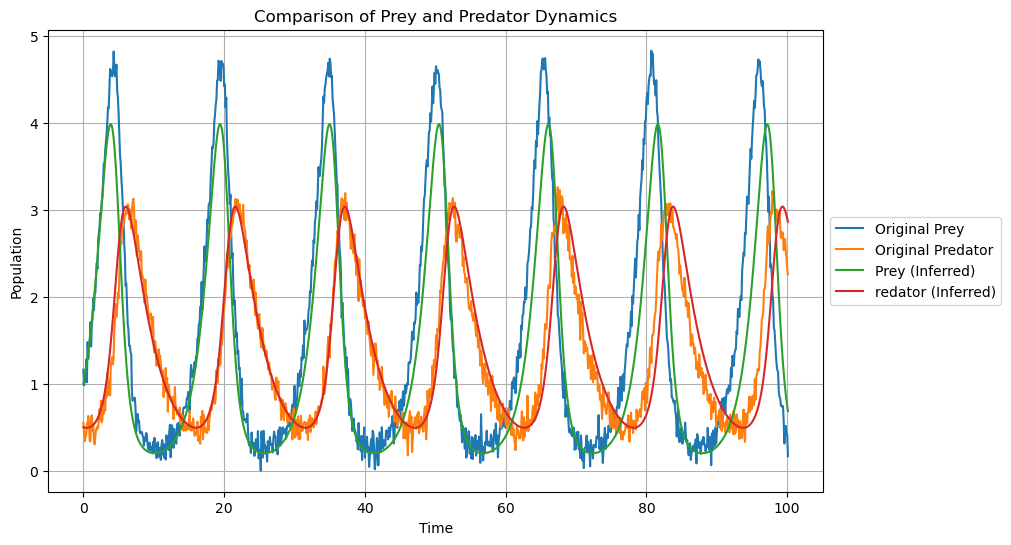

In [125]:
b_1 = 0.72
b_2 = 0.509
b_3 = 0.284
b_4 = 0.226

t_train_inf, p_train_inf, d_train_inf = generate_LV_samples(max_time, dt, b_1, b_2, b_3, b_4, t0, p0, d0, noise=False)

plt.figure(figsize=(10, 6))
plt.plot(t_train, p_train, label='Original Prey')
plt.plot(t_train, d_train, label='Original Predator')
plt.plot(t_train_inf, p_train_inf, label='Prey (Inferred)')
plt.plot(t_train_inf, d_train_inf, label='redator (Inferred)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Comparison of Prey and Predator Dynamics')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

#### Problem 1c:

Plot two scatterplots comparing the values of true (x-axis) and predicted data (y-axis) from problem 1b and compute the coefficient of determination $R^2$, for both prey and predator fits. Keep both axes equal. Judging from these plots and the ones from problem 1b, as well as the $R^2$ statistics, what do you think about the goodness of fit? Is there any systematic over- or underestimation in predictions?

#### Code and answers:

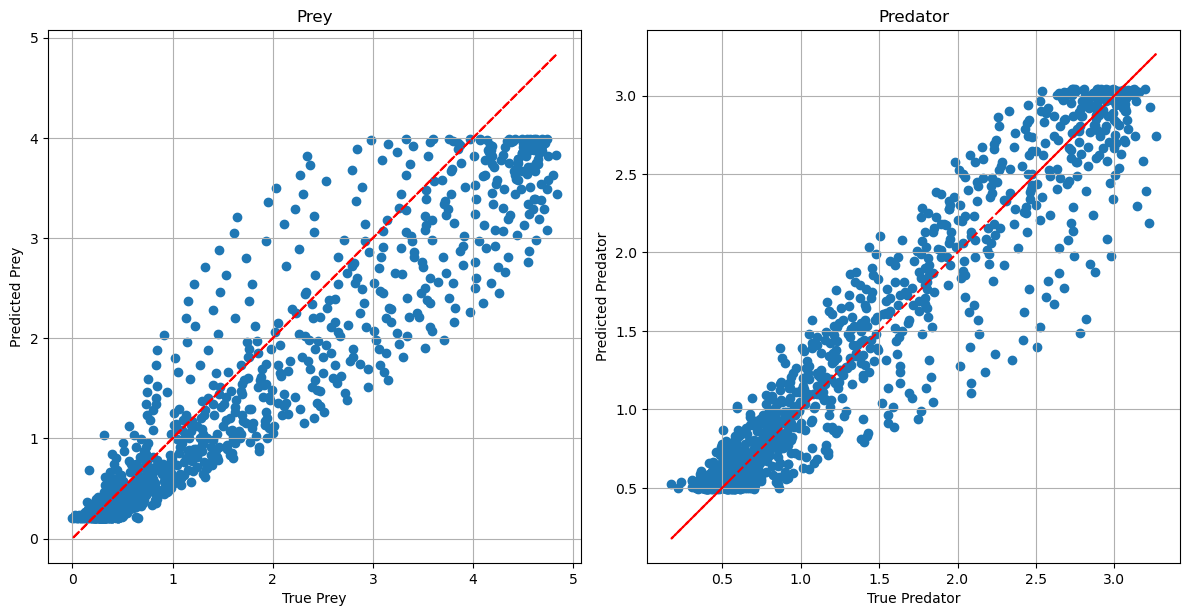

R^2 for Prey: 0.8517099410514739
R^2 for Predator: 0.9066407471742176


In [127]:
from sklearn.metrics import r2_score

r2_p = r2_score(p_train, p_train_inf)
r2_d = r2_score(d_train, d_train_inf)

plt.figure(figsize=(12, 6))

# Prey
plt.subplot(1, 2, 1)
plt.scatter(p_train, p_train_inf)
plt.plot(p_train, p_train, color='red', linestyle='--')  
plt.title('Prey')
plt.xlabel('True Prey')
plt.ylabel('Predicted Prey')
plt.axis('equal')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Predator
plt.subplot(1, 2, 2)
plt.scatter(d_train, d_train_inf)
plt.plot(d_train, d_train, color='red', linestyle='--')
plt.title('Predator')
plt.xlabel('True Predator')
plt.ylabel('Predicted Predator')
plt.axis('equal')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("R^2 for Prey:", r2_p)
print("R^2 for Predator:", r2_d)

The $R^2$ values for both preys and predators are indicating fairly strong correlation of predicted and true values. As can be seen from the plots there is more variation in the prey plot than in the predator plot. 

### Problem 2: symbolic regression on real prey-predator data

Let's take a look how SR performs on real data. Here, we have population estimates for the prey (Paramecium) and the predator (Didinium), as well as their partial derivatives with respect to each. The data is from Martin *et al.* https://doi.org/10.1098/rspb.2018.0422

In [130]:
data = pd.read_csv("ParameciumDidinium.csv")
data.head()

,Time,Paramecium (P),Didinium (D),dP/dt,dD/dt
0,0.00,16.461657,5.231674,73.941543,5.044667
1,0.52,51.735546,9.080719,53.958991,12.538306
2,1.01,73.831098,19.266671,47.755918,29.827758
3,1.54,99.913867,39.434318,36.776017,43.867604
4,2.04,104.651751,60.569484,-20.284770,35.862136


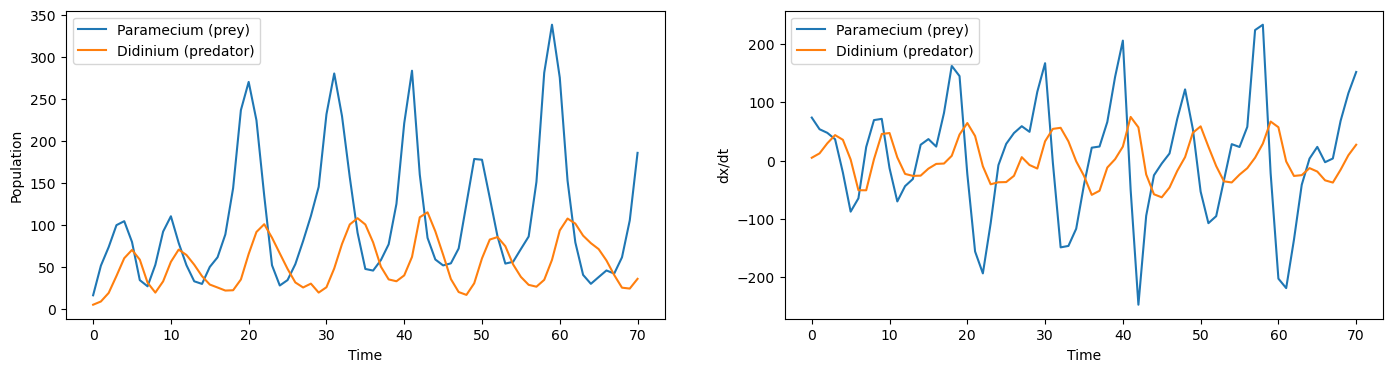

In [14]:
plt.subplots(1, 2, figsize=(17, 4))
plt.subplot(121)
plt.plot(data["Paramecium (P)"], label="Paramecium (prey)")
plt.plot(data["Didinium (D)"], label="Didinium (predator)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()

plt.subplot(122)
plt.plot(data["dP/dt"], label="Paramecium (prey)")
plt.plot(data["dD/dt"], label="Didinium (predator)")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.show()

#### Problem 2a:

Try to find symbolic equations for both prey and predator data using the SR function. Real data is expected to be a more difficult problem, as the real prey-predator dynamics are not necessarily following the exact simplified Lotka-Volterra equations presented in this notebook or they may simply be too noisy.

Evaluate and visualize the best performing equations like in the previous problems. Are any equations representative of the Lotka-Volterra formulas discussed above, either for prey, predator or both? Are their fits reasonably good in terms of their $R^2$ and value-to-value scatterplots?

There is no need to find exact representations (though it can be done), as the search might be time-prohibitive, therefore it's enough to try few instances.

Hint: if the equations SR finds are very long, try increasing the parsimony coefficient (pc in SR function) until the equations are sufficiently compact.

#### Code and answers:

In [ ]:
from sklearn.model_selection import train_test_split

In [227]:
x = data[["Paramecium (P)","Didinium (D)"]].values
p = data["dP/dt"].values
d = data["dD/dt"].values

In [185]:
# PREY
x_train_prey, x_test_prey, y_train_prey, y_test_prey = train_test_split(x, p, test_size=0.33, random_state=42)
prey_SR = SR(x_train_prey, y_train_prey, x_test_prey, y_test_prey, n=10, rng=range(10), method="grow", pc=0.2)

Model 1, R^2 score: 0.71, add(0.075, mul(add(add(add(add(d, d), div(0.994, mul(0.065, -0.196))), d), div(0.994, mul(0.065, -0.196))), -0.964))
Model 2, R^2 score: 0.88, add(add(mul(mul(p, d), -0.025), p), mul(p, 0.469))
Model 3, R^2 score: 0.76, add(add(mul(d, -0.858), add(mul(p, -0.595), div(add(p, d), mul(d, 0.078)))), div(add(d, p), mul(add(mul(-0.271, d), d), 0.078)))
Model 4, R^2 score: 0.52, add(div(add(p, d), mul(d, 0.046)), mul(-0.913, d))
Model 5, R^2 score: 0.78, add(add(div(div(p, 0.047), mul(0.796, d)), add(add(div(div(add(-0.654, p), 0.047), add(d, -0.441)), mul(add(p, 0.180), -0.420)), mul(d, -0.441))), mul(add(p, div(-0.107, mul(0.292, d))), -0.420))
Model 6, R^2 score: 0.86, add(div(p, mul(0.204, d)), add(mul(mul(mul(-0.530, 0.012), add(d, mul(-0.530, 0.012))), add(add(p, p), p)), p))
Model 7, R^2 score: 0.86, add(mul(add(mul(add(p, d), mul(0.034, add(d, -0.107))), div(d, -0.898)), -0.468), add(div(add(-0.930, p), mul(add(mul(d, -0.269), p), 0.075)), p))
Model 8, R^2 sc

In [186]:
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in prey_SR["Equation"]:
    print(simplify(convert_s(eq)))

150.501373626374 - 2.892*d
p*(1.469 - 0.025*d)
-0.858*d - 0.595*p + 30.4069501600366 + 30.4069501600366*p/d
-0.913*d + 21.7391304347826 + 21.7391304347826*p/d
(-d*(d - 0.441)*(0.441*d + 0.84*p + 0.0756) + d*(21.2765957446809*p - 13.9148936170213) + (d - 0.441)*(26.7293916390463*p + 0.153904109589041))/(d*(d - 0.441))
p*(d*(1.0001213488 - 0.01908*d) + 4.90196078431373)/d
(-p + (0.020175*d - 0.075*p)*(0.521158129175947*d + p - 0.468*(0.034*d - 0.003638)*(d + p)) + 0.93)/(0.020175*d - 0.075*p)
(24.2011278195489*d*p + (1.61812297734628 - 0.461*d)*(d*(d - 0.696) + p))/(d*(d - 0.696) + p)
(d*(-4.18410041841004*d*p + 31.25*d + 31.25*p) + 31.25*(d + p)**2)/(d*(d + p))
(-0.809*d*p + 41.2371134020619*p - 0.296016)/d


In [197]:
eq_prey = simplify(convert_s(prey_SR["Equation"][1]))
eq_prey

In [228]:
# PREDATOR
x_train_predator, x_test_predator, y_train_predator, y_test_predator = train_test_split(x, d, test_size=0.33, random_state=42)
pred_SR = SR(x_train_predator, y_train_predator, x_test_predator, y_test_predator, n=10, rng=range(10), method="grow", pc=0.51)

Model 1, R^2 score: 0.5, add(div(div(d, -0.035), p), mul(p, 0.154))
Model 2, R^2 score: -0.07, div(div(d, p), -0.075)
Model 3, R^2 score: 0.57, add(mul(0.177, p), div(div(d, -0.043), p))
Model 4, R^2 score: 0.57, add(mul(0.180, p), div(div(d, p), mul(-0.073, 0.625)))
Model 5, R^2 score: -0.16, div(div(d, -0.221), mul(p, 0.219))
Model 6, R^2 score: -0.45, mul(-0.232, d)
Model 7, R^2 score: 0.57, add(div(d, mul(-0.039, p)), mul(0.188, p))
Model 8, R^2 score: 0.46, add(add(mul(0.319, p), div(-0.103, 0.006)), div(-0.103, 0.006))
Model 9, R^2 score: 0.45, add(div(d, mul(p, -0.038)), mul(p, 0.128))
Model 10, R^2 score: 0.48, add(div(-0.525, 0.041), add(add(div(-0.959, 0.041), mul(p, 0.154)), mul(p, 0.182)))


In [229]:
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in pred_SR["Equation"]:
    print(simplify(convert_s(eq)))

-28.5714285714286*d/p + 0.154*p
-13.3333333333333*d/p
-23.2558139534884*d/p + 0.177*p
-21.9178082191781*d/p + 0.18*p
-20.6615839170231*d/p
-0.232*d
-25.6410256410256*d/p + 0.188*p
0.319*p - 34.3333333333333
-26.3157894736842*d/p + 0.128*p
0.336*p - 36.1951219512195


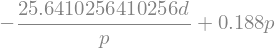

In [235]:
eq_pred = simplify(convert_s(pred_SR["Equation"][6]))
eq_pred

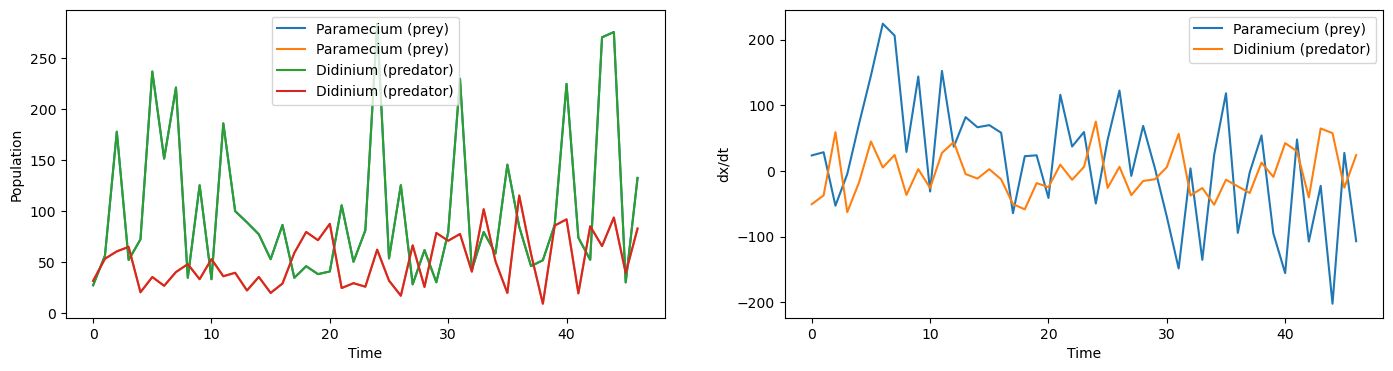

In [251]:
plt.subplots(1, 2, figsize=(17, 4))
plt.subplot(121)
plt.plot(x_train_prey, label="Paramecium (prey)")
plt.plot(x_train_predator, label="Didinium (predator)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()

plt.subplot(122)
plt.plot(y_train_prey, label="Paramecium (prey)")
plt.plot(y_train_predator, label="Didinium (predator)")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.show()